In [1]:
lookto = '/home/lscsc/caizhijie/0420-wamera-benchmark/annotate_29/3c.pk'

import pickle as pk

df = pk.load(open(lookto, 'rb'))

In [2]:
df

,csi,pic
0,[[[[-1.11920126+1.11920126j 2.23840251+2.7980...,/home/sensing/caizhijie/0702-falldewideo/data/...
1,[[[[-1.67880186+1.11920124j 1.67880186+2.7980...,/home/sensing/caizhijie/0702-falldewideo/data/...
2,[[[[0.55960062+1.67880185j 2.79800309-0.559600...,/home/sensing/caizhijie/0702-falldewideo/data/...
3,[[[[-1.11920123-1.11920123j -2.79800308+2.7980...,/home/sensing/caizhijie/0702-falldewideo/data/...
4,[[[[ 1.11920122+0.55960061j 2.23840244-2.2384...,/home/sensing/caizhijie/0702-falldewideo/data/...
...,...,...
71995,[[[[-2.23840256-0.55960064j -1.11920128+2.7980...,/home/sensing/caizhijie/0702-falldewideo/data/...
71996,[[[[-1.67880193+0.j 0. +2.7980...,/home/sensing/caizhijie/0702-falldewideo/data/...
71997,[[[[-2.23840257+0.55960064j 0.55960064+2.7980...,/home/sensing/caizhijie/0702-falldewideo/data/...
71998,[[[[ 1.67880193+1.67880193j 2.23840257-2.2384...,/home/sensing/caizhijie/0702-falldewideo/data/...


In [3]:
df.iloc[0]['pic'].replace('sensing', 'lscsc').replace('0702-falldewideo', '0420-wamera-benchmark')

'/home/lscsc/caizhijie/0420-wamera-benchmark/data/20230609_35/falldewideo_fall_czj_lights_1000_a1_5_rc/t5_2023_06_09_22_45_41_146/2023_06_09_22_45_41_348.jpg'

In [4]:
import cv2

arr = cv2.imread(df.iloc[0]['pic'].replace('sensing', 'lscsc').replace('0702-falldewideo', '0420-wamera-benchmark'))

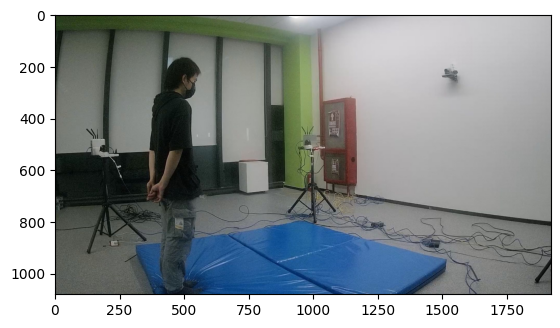

In [5]:
import matplotlib.pyplot as plt

plt.imshow(arr[..., ::-1])

In [6]:
# %%
# import some common detectron2 utilities

import torch

import os

import sys

sys.path.insert(0, '/home/lscsc/caizhijie/0710-falldewideo/external')

import detectron2

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library

yamlfile = '/home/lscsc/caizhijie/0420-wamera-benchmark/annotate/maskrcnn/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml'
# yamlfile = 'configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml'
# yamlfile = '/home/lscsc/caizhijie/0420-wamera-benchmark/annotate/maskrcnn/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml'

cfg.merge_from_file(yamlfile)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(yamlfile[11:])
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(yamlfile[70:])
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(yamlfile)

/home/lscsc/caizhijie/miniconda3/envs/falldewideo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from torch.utils.data import Dataset, DataLoader

import cv2
import torch
import tqdm
import numpy as np

class _dataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, index):
        return self.df.iloc[index]['pic'].replace('sensing', 'lscsc').replace('0702-falldewideo', '0420-wamera-benchmark')
    
    def __len__(self):
        return len(self.df)
    
def collate_fn(batch):
    imgs = [cv2.imread(_) for _ in batch]
    paths = [_ for _ in batch]
    return np.stack(imgs), paths


class packPredictor(DefaultPredictor):
    def __call__(self, pack):
        # 'NHWC'
        assert len(pack.shape) == 4, 'A default predictor is qualified'
        with torch.no_grad():
            packimage = list()
            packheight = list()
            packwidth = list()
            
            for i in range(pack.shape[0]):
                thisimage = pack[i, ...]
                if self.input_format == 'RGB':
                    thisimage = thisimage[..., ::-1]
                    
                # print(thisimage.shape)
                height, width = thisimage.shape[:2]
                image = self.aug.get_transform(thisimage).apply_image(thisimage)
                image = torch.as_tensor(image.astype('float32').transpose(2, 0, 1))
                
                packimage.append(image)
                packheight.append(height)
                packwidth.append(width)
            
            inputs = [{'image': packimage[_], 'height': packheight[_], 'width': packwidth[_]} for _ in range(len(packimage))]
            predictions = self.model(inputs)
            return predictions

In [26]:
n = 8

for k in range(n):

    dataset = _dataset(df[k * int(len(df) / n) : (k+1) * (int(len(df) / n))])
    inference_loader = DataLoader(dataset, 4, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)
    ppredictor = packPredictor(cfg)

    outputlist = list()

    for i, batch in tqdm.tqdm(enumerate(inference_loader), total=len(inference_loader)):
        output = ppredictor(batch[0][:, ::5, ::5, :])
        
        dump = [_['instances'].to('cpu').get_fields() for _ in output]

        for _ in dump:
            try:
                outputlist.append(_['pred_masks'][torch.where(_['pred_classes'] == 0)[0]][0, ::4, ::4].cpu().detach().numpy())
            except IndexError:
                outputlist.append((torch.zeros((54, 96)) == 1).cpu().detach().numpy())
                
    df['maskrcnn'] = outputlist
    pk.dump(df[['maskrcnn', 'pic']], open('/home/lscsc/caizhijie/0710-falldewideo/annotate/maskrcnn/data/3c_%d.pk' % k, 'wb'))

  2%|▏         | 302/18000 [02:44<2:40:11,  1.84it/s]


KeyboardInterrupt: 